In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch 
import os
import glob
from matplotlib import pyplot as plt
import seaborn as sns
import os
import torch
import collections
# Cd to code
import os
import sys
os.chdir('/cluster/home/kheuto01/code/prob_diff_topk')
sys.path.append('/cluster/home/kheuto01/code/prob_diff_topk')

from datasets import example_datasets, to_numpy
from torch_models import  MixtureOfTruncNormModel, torch_bpr_uncurried, deterministic_bpr
#from torch_perturb.torch_pert_topk import PerturbedTopK
from distributions import QuantizedNormal



2024-10-28 10:09:45.337346: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-28 10:09:45.387781: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-28 10:09:45.387816: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-28 10:09:45.389042: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-28 10:09:45.397615: I tensorflow/core/platform/cpu_feature_guar

In [ ]:
base_dir = '/cluster/tufts/hugheslab/kheuto01/frontier_4000_comp2'
exps = glob.glob(base_dir + '/*')
len(exps)

260

In [3]:
seed=360
# tracts/distributions
S=7

# total timepoints
T= 500
K=5

dist_S = [QuantizedNormal(10, 0.3),
          QuantizedNormal(20, 0.3),
          QuantizedNormal(30, 0.3),
          QuantizedNormal(40, 0.3),
          QuantizedNormal(50, 0.3),
          QuantizedNormal(60, 0.3),
          QuantizedNormal(100, 0.3)]

train_y_TS = np.zeros((T, S))
for s, dist in enumerate(dist_S):
    random_state = np.random.RandomState(10000 * seed + s*123456)
    train_y_TS[:, s] = dist.rvs(size=T, random_state=random_state)

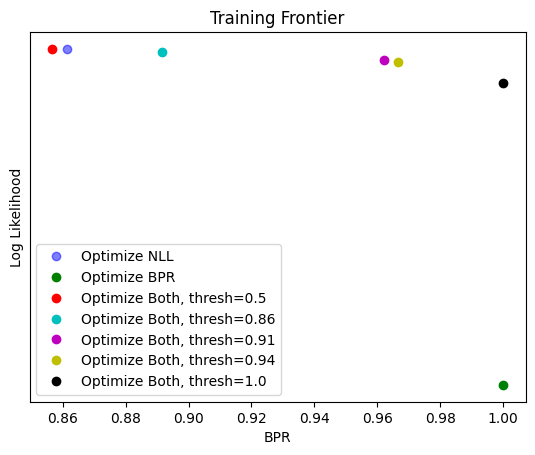

In [4]:
nll_bprs = []
nll_nlls = []
nll_bprs_by_init = -np.inf
nll_nlls_by_init = -np.inf
nll_losses_by_init = np.inf
nll_exp_by_init = collections.defaultdict(str)
bpr_bprs = []
bpr_nlls = []
bpr_bprs_by_init = -np.inf
bpr_nlls_by_init = -np.inf
bpr_losses_by_init = np.inf
bpr_exp_by_init = collections.defaultdict(str)
both_bprs = []
both_nlls = []
both_bprs_by_thresh = collections.defaultdict(lambda: -np.inf)
both_nlls_by_thresh = collections.defaultdict(lambda: -np.inf)
both_losses_by_thresh = collections.defaultdict(lambda: np.inf)
both_exp_by_thresh = collections.defaultdict(lambda: collections.defaultdict(str))
max_nll = -np.inf

for e,exp in enumerate(exps):
    losses = torch.load(exp + '/losses.pth')
    bprs = torch.load(exp + '/bprs.pth')
    nlls = torch.load(exp + '/nlls.pth')

    losses = np.array([loss.detach().numpy() for loss in losses])
    bprs = np.array([bpr.detach().numpy() for bpr in bprs])
    nlls = np.array([nll.detach().numpy() for nll in nlls])
    bw = exp.split('bw')[1].split('_')[0]
    nw = exp.split('nw')[1].split('_')[0]
    init = int(exp.split('init')[-1])
    if 'tr' in exp:
        thresh = float(exp.split('_tr')[-1].split('_')[0])
    else:
        thresh = 0

    bpr = bprs[-1]
    nll = -nlls[-1]
    loss = losses[-1]
    if nll > max_nll:
        max_nll = nll


    if bw=='0':
        nll_bprs.append(bprs[-1])
        nll_nlls.append(-nlls[-1])
        if nll > nll_nlls_by_init:
            nll_nlls_by_init = nll
            nll_bprs_by_init = bpr
            nll_exp_by_init = exp
    elif nw=='0':
        bpr_bprs.append(bprs[-1])
        bpr_nlls.append(-nlls[-1])
        if bpr >= bpr_bprs_by_init:
            if nll > bpr_nlls_by_init:
                bpr_bprs_by_init = bpr
                bpr_nlls_by_init = nll
                bpr_exp_by_init = exp
    else:
        both_bprs.append(bprs[-1])
        both_nlls.append(-nlls[-1])
        if loss < both_losses_by_thresh[thresh]:
            both_bprs_by_thresh[thresh] = bpr
            both_nlls_by_thresh[thresh] = nll
            both_losses_by_thresh[thresh] = loss
            both_exp_by_thresh[thresh] = exp

plt.plot(nll_bprs_by_init, nll_nlls_by_init, 'bo',alpha=0.5, label='Optimize NLL')
plt.plot(bpr_bprs_by_init, bpr_nlls_by_init, 'go', label='Optimize BPR')
# plot best of both with each thresh in a different color
colors = ['r', 'c', 'm', 'y', 'k']

for i, thresh in enumerate(both_bprs_by_thresh.keys()):
    plt.plot(both_bprs_by_thresh[thresh], both_nlls_by_thresh[thresh], f'{colors[i]}o', label=f'Optimize Both, thresh={thresh}')
plt.xlabel('BPR')
plt.ylabel('Log Likelihood')
# set ylimits to -100000 to 0
#plt.ylim(-1100000, -1000)
# make y axis log scale even with negative values
plt.yscale('symlog', linthresh=1)
plt.title('Training Frontier')
plt.legend()

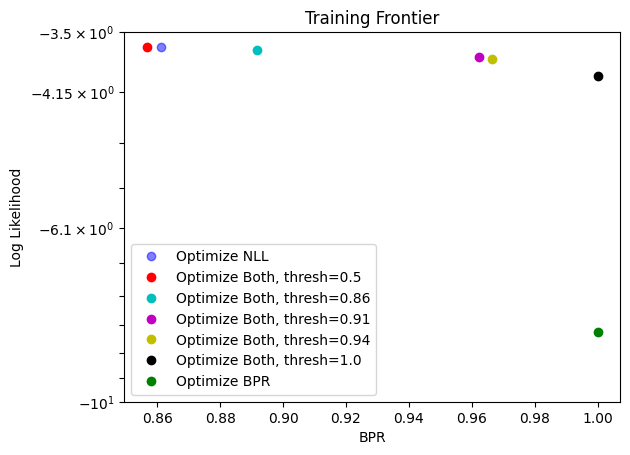

In [5]:
plt.plot(nll_bprs_by_init, nll_nlls_by_init, 'bo',alpha=0.5, label='Optimize NLL')

# plot best of both with each thresh in a different color
colors = ['r', 'c', 'm', 'y', 'k']

for i, thresh in enumerate(both_bprs_by_thresh.keys()):
    plt.plot(both_bprs_by_thresh[thresh], both_nlls_by_thresh[thresh], f'{colors[i]}o', label=f'Optimize Both, thresh={thresh}')
plt.plot(bpr_bprs_by_init, bpr_nlls_by_init, 'go', label='Optimize BPR')
plt.xlabel('BPR')
plt.ylabel('Log Likelihood')
# set ylimits to -100000 to 0
#plt.ylim(-1100000, -1000)
# make y axis log scale even with negative values
plt.yscale('symlog', linthresh=1)
# more y ticks
plt.yticks(np.linspace(-10, -3.5, 11))
plt.title('Training Frontier')
plt.legend()

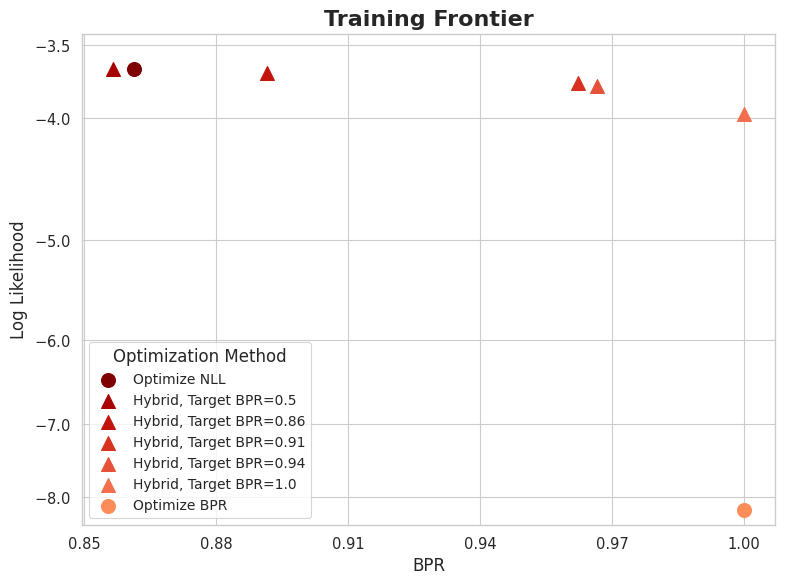

In [6]:
import pandas as pd
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import ScalarFormatter

# Set the style for a clean, professional look
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.2)

# Create a custom OrangeRed colormap
colors =['#7F0000', '#B30000', '#D7301F', '#EF6548', '#FC8D59',]# '#FDBB84', '#FDD49E', '#FEE8C8', '#FFF7EC']
n_bins = 100
cmap = LinearSegmentedColormap.from_list('custom_orangered', colors, N=n_bins)
# Create a DataFrame for easier plotting
data = []
for thresh in both_bprs_by_thresh.keys():
    data.append({"BPR": both_bprs_by_thresh[thresh], "Log Likelihood": both_nlls_by_thresh[thresh], "Optimization": f"Hybrid, Target BPR={thresh}"})
data.append({"BPR": nll_bprs_by_init, "Log Likelihood": nll_nlls_by_init, "Optimization": "Optimize NLL"})
data.append({"BPR": bpr_bprs_by_init, "Log Likelihood": bpr_nlls_by_init, "Optimization": "Optimize BPR"})


df = pd.DataFrame(data)

# Calculate y-axis limits based on the data
y_min = df['Log Likelihood'].min()
y_max = df['Log Likelihood'].max()
y_range = y_max - y_min
y_padding = 0.05 * y_range  # 5% padding
y_min_padded = y_min - y_padding
y_max_padded = y_max + y_padding

# Create the plot
plt.figure(figsize=(8,6))

# Plot "Optimize Both" points
both_data = df[df['Optimization'].str.contains('Hybrid')]
both_colors = cmap(np.linspace(0.2, 0.8, len(both_data)))
for (_, row), color in zip(both_data.iterrows(), both_colors):
    plt.scatter(row['BPR'], row['Log Likelihood'], color=color, s=100, marker='^', label=row['Optimization'])

# Plot "Optimize NLL" points
nll_data = df[df['Optimization'] == 'Optimize NLL']
plt.scatter(nll_data['BPR'], nll_data['Log Likelihood'], color=colors[0], s=100, marker='o', label='Optimize NLL')

# Plot "Optimize BPR" points
bpr_data = df[df['Optimization'] == 'Optimize BPR']
plt.scatter(bpr_data['BPR'], bpr_data['Log Likelihood'], color=colors[-1], s=100, marker='o', label='Optimize BPR')

# Customize the plot
plt.title("Training Frontier", fontsize=16, fontweight='bold')
plt.xlabel("BPR", fontsize=12)
plt.ylabel("Log Likelihood", fontsize=12)

# Set y-axis to symlog scale with data-driven limits


# add x and y ticks
plt.xticks(np.linspace(0.85, 1, 6))
# make y ticks log space between -8.5 and -3.5


#plt.ylim(y_min_padded, y_max_padded)
plt.yscale('symlog', linthresh=0.1)
# Create a ScalarFormatter object
formatter = ScalarFormatter(useOffset=False)

# Set the formatter to use a fixed number of decimal places
formatter.set_scientific(False)
formatter.set_useMathText(True)

# Apply the formatter to the y-axis
plt.gca().yaxis.set_major_formatter(formatter)
plt.yticks([ -3.5,-4,-5,-6,-7, -8])

# Adjust legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))

# Create a list of labels in the desired order
desired_order = ['Optimize NLL'] + [label for label in labels if label not in ['Optimize NLL', 'Optimize BPR']] + ['Optimize BPR']

# Create the legend with the desired order
plt.legend([by_label[label] for label in desired_order], desired_order,
          title="Optimization Method", title_fontsize='12', fontsize='10', 
          loc='lower left')

# Adjust layout to prevent cutoff
plt.tight_layout()

In [7]:
both_exp_by_thresh

defaultdict(<function __main__.<lambda>()>,
            {0.5: '/cluster/tufts/hugheslab/kheuto01/frontier_4000_comp2/bw30_nw1_ss0.1_sig0.01_tr0.5_init5',
             0.86: '/cluster/tufts/hugheslab/kheuto01/frontier_4000_comp2/bw30_nw1_ss0.1_sig0.05_tr0.86_init0',
             0.91: '/cluster/tufts/hugheslab/kheuto01/frontier_4000_comp2/bw30_nw1_ss0.1_sig0.01_tr0.91_init11',
             0.94: '/cluster/tufts/hugheslab/kheuto01/frontier_4000_comp2/bw30_nw1_ss0.1_sig0.01_tr0.94_init7',
             1.0: '/cluster/tufts/hugheslab/kheuto01/frontier_4000_comp2/bw30_nw1_ss0.1_sig0.01_tr1_init4'})

In [6]:
best_nll_model = MixtureOfTruncNormModel(num_components=2, S=S)
# load state dict
best_nll_model.load_state_dict(torch.load(nll_exp_by_init + '/model.pth'))
best_bpr_model = MixtureOfTruncNormModel(num_components=2, S=S) 
best_bpr_model.load_state_dict(torch.load(bpr_exp_by_init + '/model.pth'))


# get best models for all the threshold models
best_thresh_models = {}
for thresh in both_exp_by_thresh.keys():
    best_thresh_models[thresh] = MixtureOfTruncNormModel(num_components=2, S=S)
    best_thresh_models[thresh].load_state_dict(torch.load(both_exp_by_thresh[thresh] + '/model.pth'))

In [7]:
best_nll_distribution = best_nll_model()
best_bpr_distribution = best_bpr_model()
best_thresh_distributions = {}
for thresh in best_thresh_models.keys():
    best_thresh_distributions[thresh] = best_thresh_models[thresh]()

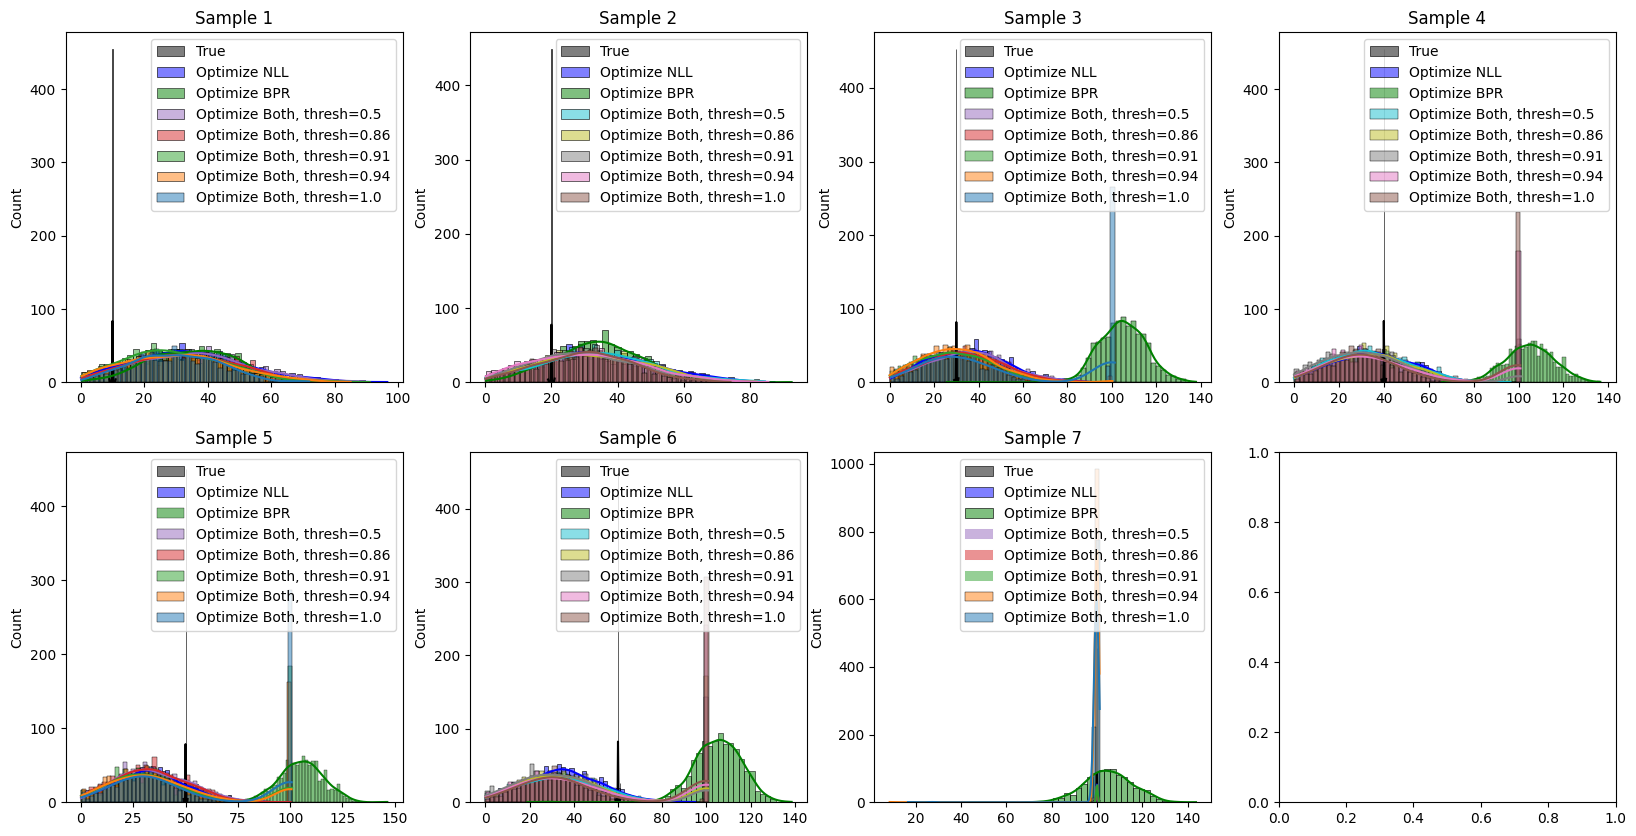

In [8]:
# plot samples from all the best models

# take samples
n_samples = 1000
nll_samples = best_nll_distribution.sample((n_samples,))
bpr_samples = best_bpr_distribution.sample((n_samples,))
thresh_samples = {}
for thresh in best_thresh_distributions.keys():
    thresh_samples[thresh] = best_thresh_distributions[thresh].sample((n_samples,))

# create len S,thresh list of colors
colors_S = sns.color_palette('tab10', S*len(best_thresh_distributions.keys()))

# plot samples
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
axs = axs.flatten()
for s in range(S):
    sns.histplot(train_y_TS[:, s], bins=50, ax=axs[s], color='black', label='True', kde=True)
    sns.histplot(nll_samples[:, s], bins=50, ax=axs[s], color='blue', label='Optimize NLL', kde=True)
    sns.histplot(bpr_samples[:, s], bins=50, ax=axs[s], color='green', label='Optimize BPR', kde=True)
    for thresh in thresh_samples.keys():
        sns.histplot(thresh_samples[thresh][:, s], bins=50, ax=axs[s], color=colors_S.pop(), label=f'Optimize Both, thresh={thresh}', kde=True)
    axs[s].set_title(f'Sample {s+1}')
    axs[s].legend()

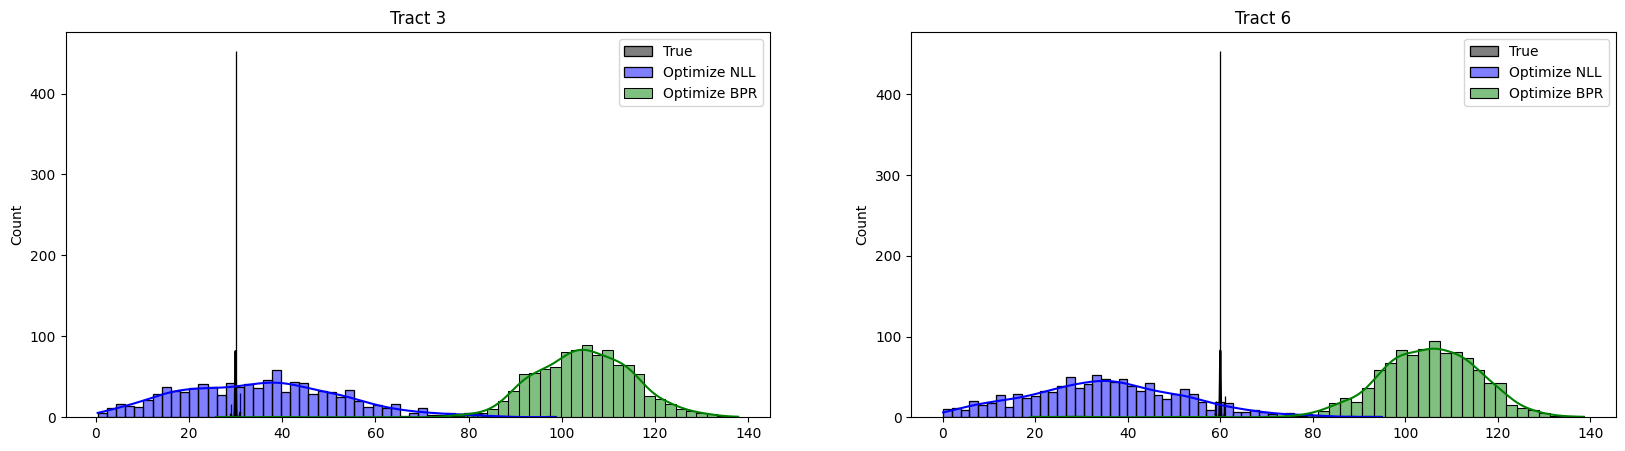

In [13]:
# for only tract 3 and 6 plot only NLL and BPR
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
sns.histplot(train_y_TS[:, 2], bins=50, ax=axs[0], color='black', label='True', kde=True)
sns.histplot(nll_samples[:, 2], bins=50, ax=axs[0], color='blue', label='Optimize NLL', kde=True)
sns.histplot(bpr_samples[:, 2], bins=50, ax=axs[0], color='green', label='Optimize BPR', kde=True)
axs[0].set_title('Tract 3')
axs[0].legend()
# plot on axs[1]
sns.histplot(train_y_TS[:, 5], bins=50, ax=axs[1], color='black', label='True', kde=True,)
sns.histplot(nll_samples[:, 5], bins=50, ax=axs[1], color='blue', label='Optimize NLL', kde=True)
sns.histplot(bpr_samples[:, 5], bins=50, ax=axs[1], color='green', label='Optimize BPR', kde=True)
axs[1].set_title('Tract 6')
axs[1].legend()


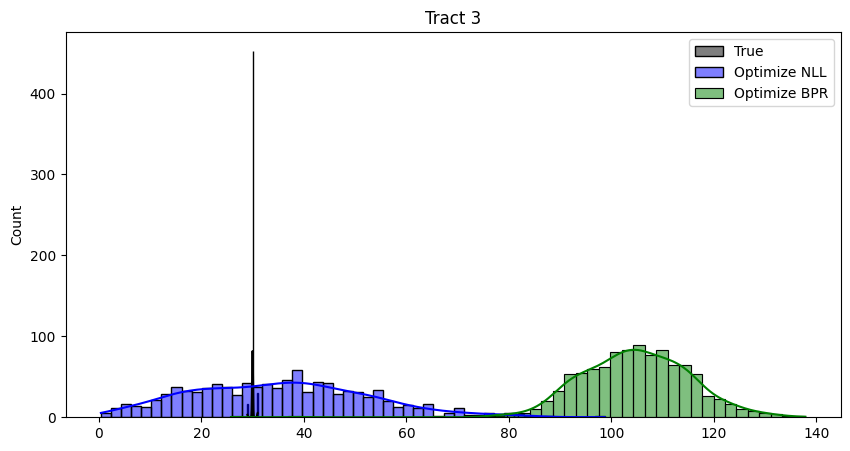

In [14]:
# for only tract 6, plot only NLL and BPR
s=2
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.histplot(train_y_TS[:, s], bins=50, ax=ax, color='black', label='True', kde=True)
sns.histplot(nll_samples[:, s], bins=50, ax=ax, color='blue', label='Optimize NLL', kde=True)
sns.histplot(bpr_samples[:, s], bins=50, ax=ax, color='green', label='Optimize BPR', kde=True)
ax.set_title(f'Tract {s+1}')
ax.legend()


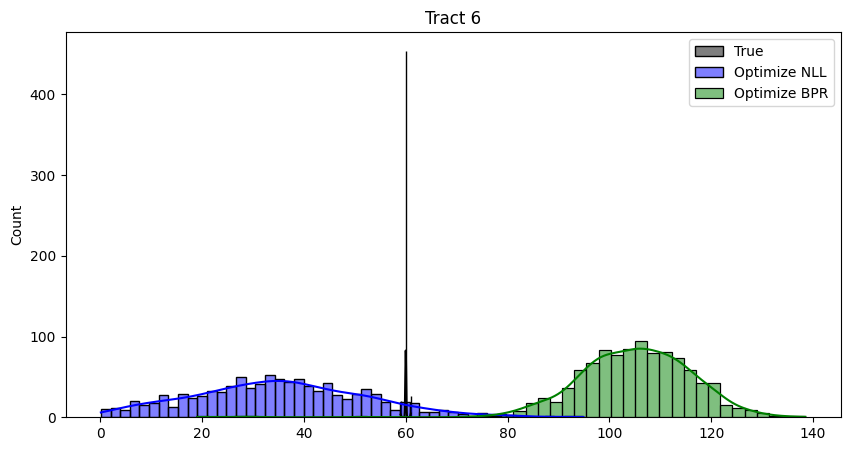

In [10]:
# for only tract 6, plot only NLL and BPR
s=5
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.histplot(train_y_TS[:, s], bins=50, ax=ax, color='black', label='True', kde=True)
sns.histplot(nll_samples[:, s], bins=50, ax=ax, color='blue', label='Optimize NLL', kde=True)
sns.histplot(bpr_samples[:, s], bins=50, ax=ax, color='green', label='Optimize BPR', kde=True)
ax.set_title(f'Tract {s+1}')
ax.legend()


In [48]:
best_nll_model[0.91].component_distribution.mean

tensor([[ 30.5325, 100.0031],
        [ 30.5325, 100.0031],
        [ 30.5325, 100.0031],
        [ 30.5325, 100.0031],
        [ 30.5325, 100.0031],
        [ 30.5325, 100.0031],
        [ 30.5325, 100.0031]], grad_fn=<AddBackward0>)

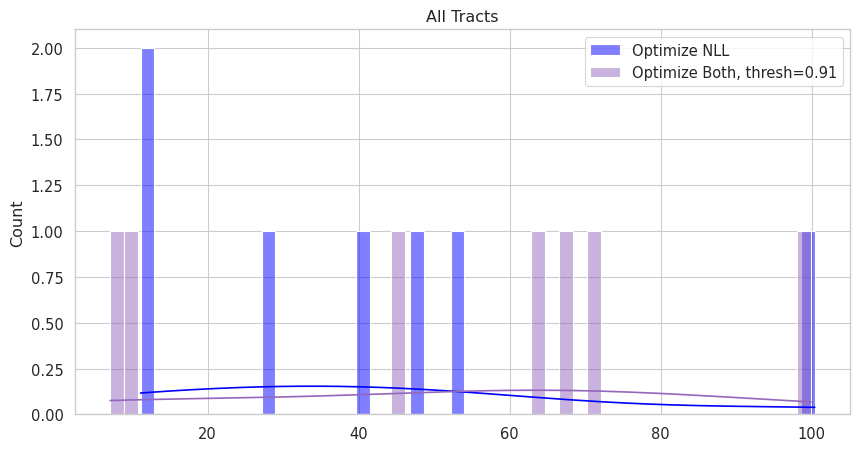

In [28]:
sample_num = 3
# plot the samples, but group all tracts together
#on only 1 figure, no subplots
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# create len S,thresh list of colors
colors_S = sns.color_palette('tab10', S*len(best_thresh_distributions.keys()))

#sns.histplot(train_y_TS[sample_num,:].flatten(), bins=50, ax=ax, color='black', label='True', kde=True)
sns.histplot(nll_samples[sample_num,:].flatten(), bins=50, ax=ax, color='blue', label='Optimize NLL', kde=True)
#sns.histplot(bpr_samples.flatten(), bins=50, ax=ax, color='green', label='Optimize BPR', kde=True)
for thresh in thresh_samples.keys():
        if thresh not in [ 0.91]:
                continue
        sns.histplot(thresh_samples[thresh][sample_num, :].flatten(), bins=50, ax=ax, color=colors_S.pop(), label=f'Optimize Both, thresh={thresh}', kde=True)
ax.set_title('All Tracts')
ax.legend()

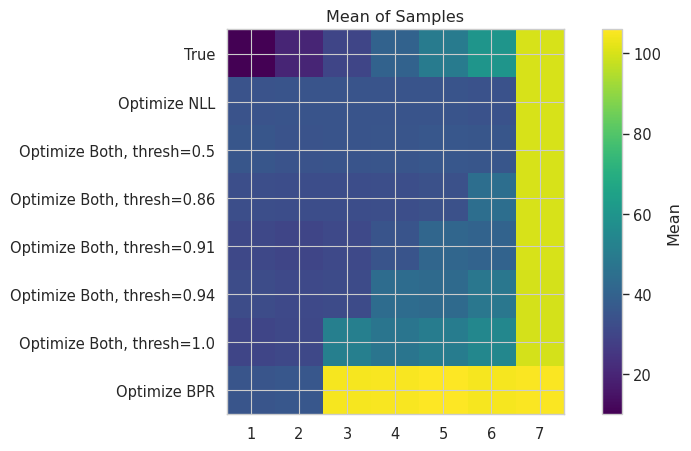

In [14]:
# plot an image where rows are the different models and columns are the different tracts
# the pixel values should be the average mean of the samples for that tract under that model
# create a list of all the samples
samples = [train_y_TS]
samples.append(nll_samples)
for thresh in thresh_samples.keys():
    samples.append(thresh_samples[thresh])
samples.append(bpr_samples)

# calculate each tracts mean under each model
means = np.zeros((len(samples), S))
for i, sample in enumerate(samples):
    means[i] = sample.mean(axis=0)

# plot the means
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.imshow(means, cmap='viridis')
ax.set_xticks(np.arange(S))
ax.set_xticklabels(np.arange(S)+1)
ax.set_yticks(np.arange(len(samples)))
ax.set_yticklabels(['True', 'Optimize NLL'] + [f'Optimize Both, thresh={thresh}' for thresh in thresh_samples.keys()] +['Optimize BPR'])
ax.set_title('Mean of Samples')
# add colorbar
cbar = ax.figure.colorbar(ax.imshow(means, cmap='viridis'), ax=ax)
cbar.set_label('Mean')
plt.show()


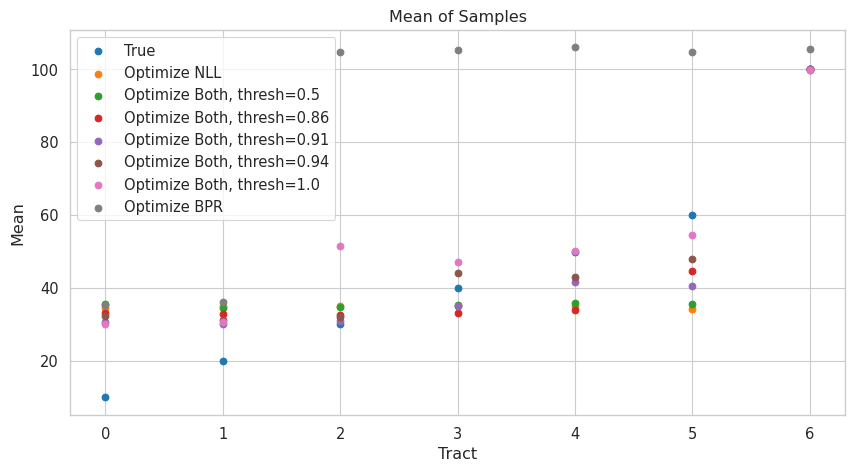

In [16]:
# plot means as scatter plots now
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
labels = ['True', 'Optimize NLL'] + [f'Optimize Both, thresh={thresh}' for thresh in thresh_samples.keys()] +['Optimize BPR']
for i in range(len(samples)):
    axs.scatter(np.arange(S), means[i], label=f'{labels[i]}')
axs.set_xlabel('Tract')
axs.set_ylabel('Mean')
axs.set_title('Mean of Samples')
axs.legend()
plt.show()


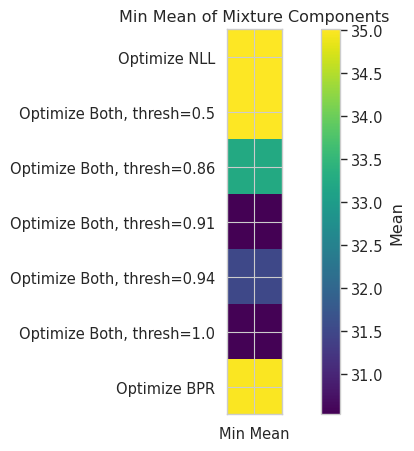

In [60]:
# plot an image where rows are the different models and columns are the different tracts
# the pixel values should be the distribution's mixture distribution's smallest mean
# create a list of all the component distribution means
means = []
means.append(best_nll_distribution.component_distribution.mean.min())
for thresh in best_thresh_distributions.keys():
    means.append(best_thresh_distributions[thresh].component_distribution.mean.min())
means.append(best_bpr_distribution.component_distribution.mean.min())

means = np.expand_dims([mean.detach().numpy() for mean in means],1)
# plot the means
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.imshow(means, cmap='viridis')
ax.set_yticks(np.arange(len(means)))
ax.set_yticklabels(['Optimize NLL'] + [f'Optimize Both, thresh={thresh}' for thresh in best_thresh_distributions.keys()] + ['Optimize BPR'])
ax.set_xticks([0])
ax.set_xticklabels(['Min Mean'])
ax.set_title('Min Mean of Mixture Components')
# add colorbar
cbar = ax.figure.colorbar(ax.imshow(means, cmap='viridis'), ax=ax)
cbar.set_label('Mean')
plt.show()


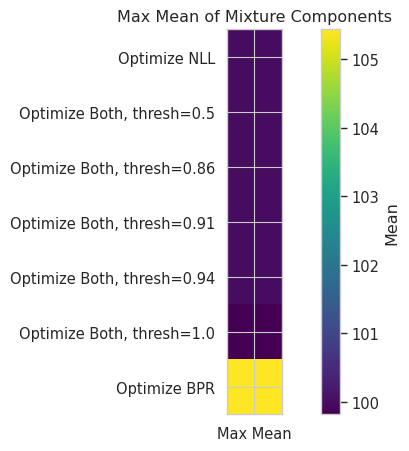

In [61]:
# do the same for max# plot an image where rows are the different models and columns are the different tracts
# the pixel values should be the distribution's mixture distribution's smallest mean
# create a list of all the component distribution means
means = []
means.append(best_nll_distribution.component_distribution.mean.max())
for thresh in best_thresh_distributions.keys():
    means.append(best_thresh_distributions[thresh].component_distribution.mean.max())
means.append(best_bpr_distribution.component_distribution.mean.max())

means = np.expand_dims([mean.detach().numpy() for mean in means],1)
# plot the means
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.imshow(means, cmap='viridis')
ax.set_yticks(np.arange(len(means)))
ax.set_yticklabels(['Optimize NLL'] + [f'Optimize Both, thresh={thresh}' for thresh in best_thresh_distributions.keys()] + ['Optimize BPR'])
ax.set_xticks([0])
ax.set_xticklabels(['Max Mean'])
ax.set_title('Max Mean of Mixture Components')
# add colorbar
cbar = ax.figure.colorbar(ax.imshow(means, cmap='viridis'), ax=ax)
cbar.set_label('Mean')
plt.show()



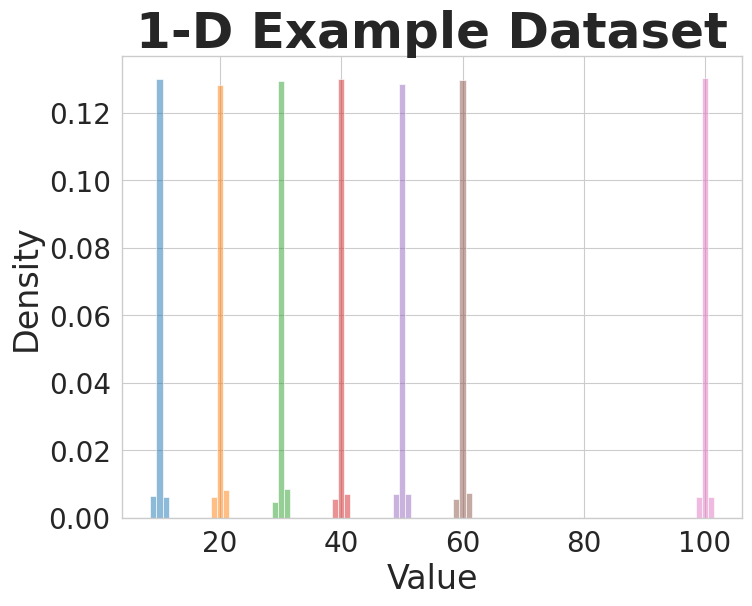

In [45]:
# Plot a good looking seaborn plot of the  the histogram of the training data
# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))
# plot training data histogram as a univariate outcome with a pleasing blue color
sns.histplot(train_y_TS[:, :], bins=50, color='blue', stat='density',
             kde=False, ax=ax, discrete=True, legend=False)
# label the x axis "Value"
ax.set_xlabel("Value", fontsize=24)
ax.set_ylabel("Density", fontsize=24)
# set the title
ax.set_title("1-D Example Dataset", fontsize=36, fontweight='bold')
# make the ticks size 20 font
ax.tick_params(axis='both', which='major', labelsize=20)

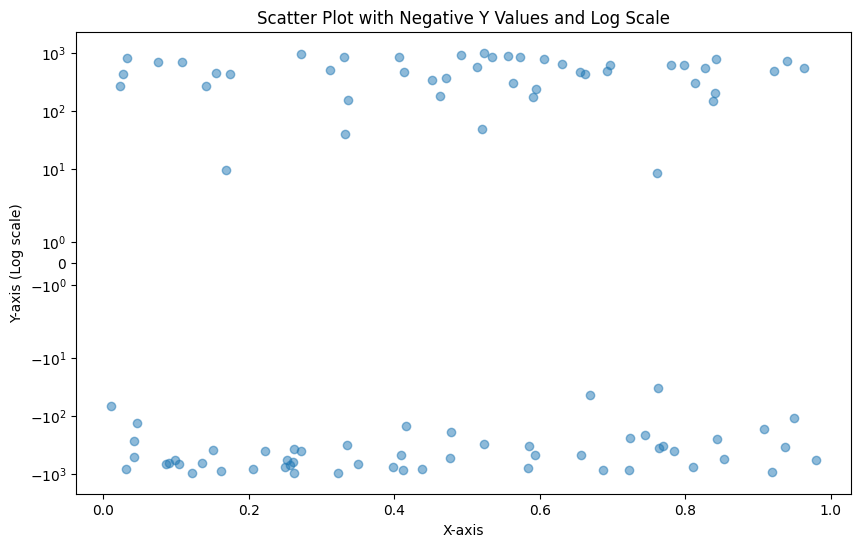

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data (replace with your actual data)
x = np.random.rand(100)
y = np.random.uniform(-1000, 1000, 100)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.5)

# Set labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis (Log scale)')
plt.title('Scatter Plot with Negative Y Values and Log Scale')

# Set y-axis to symlog scale
plt.yscale('symlog', linthresh=3)

# Adjust y-axis ticks if needed
plt.yticks([-1000, -100, -10, -1, 0, 1, 10, 100, 1000])

# Show the plot
#plt.grid(True)
plt.show()